# Macro Data Scientist Internship Process Test

Séries da Inflação dos EUA (CPI) do BLS (Bureau of Labor Statistics) obtida via API através do site: https://www.bls.gov/

### Question 1

In [1]:
import requests
import json
import pandas as pd
import prettytable

# Configuração da API
headers = {"Content-type": "application/json"}
data = json.dumps({
    "seriesid": ["SUUR0000SA0", "SUUR0000SA0L1E", "CUSR0000SETB01"],
    "startyear": "2019",
    "endyear": "2024"
})

# Fazer a requisição para a API
response = requests.post("https://api.bls.gov/publicAPI/v2/timeseries/data/", data=data, headers=headers)
json_data = json.loads(response.text)

# Processar os dados retornados
data_frames = {}
for series in json_data["Results"]["series"]:
    series_id = series["seriesID"]
    series_data = []
    for item in series["data"]:
        year = item["year"]
        period = item["period"]
        value = float(item["value"])
        if "M01" <= period <= "M12":
            date = f"{year}-{period[1:]}"
            series_data.append({"date": date, series_id: value})
    data_frames[series_id] = pd.DataFrame(series_data).set_index("date")
# Concatenar os dados em um único DataFrame
final_df = pd.concat(data_frames.values(), axis=1)

# Salvar em um arquivo CSV
final_df.to_csv("cpi_data.csv")

print("Dados salvos com sucesso em 'cpi_data.csv'.")


Dados salvos com sucesso em 'cpi_data.csv'.


In [2]:
table = pd.read_csv("cpi_data.csv")

table.head()

,date,SUUR0000SA0,SUUR0000SA0L1E,CUSR0000SETB01
0,2024-06,175.128,166.165,294.968
1,2024-05,175.123,166.000,306.599
2,2024-04,174.868,165.694,318.186
3,2024-03,174.190,165.257,309.587
4,2024-02,173.045,164.409,304.302


- Ao salvar os dados em formato CSV, é possível visualizá-los utilizando a biblioteca Pandas.
- Conforme pedido na questão 2, foi extraída as datas de 2019 a 2024.

Os códigos representam as seguintes séries:
  - SUUR0000SA0 - All Items
  - SUUR0000SA0L1E- Less Food and Energy
  - CUSR0000SETB01 - Gasoline (all types)


In [3]:
table.shape

(66, 4)

O dataframe possui 66 linhas e 4 colunas

In [4]:
table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            66 non-null     object 
 1   SUUR0000SA0     66 non-null     float64
 2   SUUR0000SA0L1E  66 non-null     float64
 3   CUSR0000SETB01  66 non-null     float64
dtypes: float64(3), object(1)
memory usage: 2.2+ KB


- Através do código acima, é possível verificar os tipos de dados que contém o dataframe.
- Não há valores nulos, porém, a coluna "date" está como objeto. É necessário transformá-la para datetime.

In [5]:
table["date"] = pd.to_datetime(table["date"])


In [6]:
table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            66 non-null     datetime64[ns]
 1   SUUR0000SA0     66 non-null     float64       
 2   SUUR0000SA0L1E  66 non-null     float64       
 3   CUSR0000SETB01  66 non-null     float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 2.2 KB


- Ao realizar a transformação, verifica-se novamente as informações para ver se a coluna realmente foi transformada para datetime.

### Question 2

In [7]:
table.sort_index(inplace=True)

In [8]:
import plotly.express as px


# Definir a coluna 'date' como índice
table.set_index("date", inplace=True)


# Cálculo da variação percentual ano-a-ano para cada série
change = table.pct_change(periods=1) * 100

# Filtragem para remover linhas com valores NaN (que resultam do cálculo de pct_change)
change.dropna()

# Gráfico da variação percentual
fig = px.line(change, x=change.index.strftime("%Y-%m"), y=change.columns,
              labels={"value": "Variação Percentual (%)",
                      "variable": "Série"},
              title="Variação Percentual das Séries de CPI (Ano a Ano)")

# Ajuste do layout do gráfico
fig.update_layout(xaxis_title="Data", yaxis_title="Variação Percentual (%)",
                  legend_title_text="Série")

# Gráfico
fig.show()


### Question 3:

- Para realizar as automatizações, pode-se utilizar a biblioteca BeautifulSoup.

- Pode-se utilizar um serviço como o cron no Linux ou o Agendador de tarefas no Windows para agendar a execução do script de coleta de dados a fim de atualizar os dados automaticamente.

- Para realizar o gerenciamento de histórico, é preciso armazenar os dados extraídos num banco de dados ou repositório para análise histórica e acompanhamento de tendências ao longo do tempo.

### Question 4




- A correlação mede o grau de dependência entre variáveis da tabela, dessa maneira, é possível saber o quanto uma variável interfere na através do cálculo da correlação entre as colunas "All Items" e "Gasoline".
- Nesse caso, o gráfico de dispersão é o que melhor se adequa para visualizar o relacionamento entre essas duas variáveis.

In [9]:
import matplotlib.pyplot as plt

# Calculo da correlação
correlacao = table["SUUR0000SA0"].corr(table["CUSR0000SETB01"])
print(f"Correlação entre All items e Gasoline: {correlacao:.2f}")

Correlação entre All items e Gasoline: 0.81


- O cálculo mostra uma correlação positiva forte, apresentando resultado de 0.81.

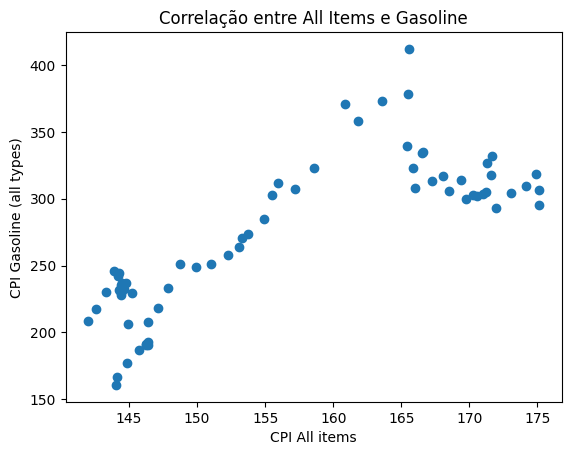

In [10]:
# Gráfico de dispersão

plt.scatter(table["SUUR0000SA0"], table["CUSR0000SETB01"])
plt.xlabel("CPI All items")
plt.ylabel("CPI Gasoline (all types)")
plt.title("Correlação entre All Items e Gasoline")
plt.show()

### Bonus Question

In [11]:
! pip install fastapi

In [12]:
from fastapi import FastAPI
import uvicorn
import nest_asyncio

app = FastAPI()

@app.get('/data')
def get_data():
    return table.to_dict(orient='index')

# Rodar a aplicação
if __name__ == '__main__':

    # Patch que permite o uso de uvicorn.run num notebook
    nest_asyncio.apply()
    uvicorn.run(app, host="127.0.0.1", port=8000)

INFO:     Started server process [79017]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)
INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [79017]
